<a href="https://colab.research.google.com/github/baochi0212/ML_project_midterm-/blob/master/ML_midterm_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/baochi0212/ML_project_midterm-

Cloning into 'ML_project_midterm-'...
remote: Enumerating objects: 3826, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 3826 (delta 12), reused 17 (delta 6), pack-reused 3801
Receiving objects: 100% (3826/3826), 54.86 MiB | 31.46 MiB/s, done.
Resolving deltas: 100% (665/665), done.


In [2]:
#upload your kaggle api key here
!pip install -q kaggle
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
%cd ML_project_midterm-

/content/ML_project_midterm-


In [5]:
!bash download.sh

 91% 55.0M/60.3M [00:01<00:00, 38.7MB/s]
100% 60.3M/60.3M [00:01<00:00, 34.7MB/s]
  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 159MB/s]


In [6]:
!mkdir data

In [7]:
#subfolder
!cd data && mkdir interim external raw processed

In [8]:
!mv -t data/raw fer2013.zip

In [9]:
!mv ckplus.zip data/external

In [10]:
!cd data/raw  &&  unzip fer2013.zip
!cd data/external && unzip ckplus.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/surprise/Training_1353800.jpg  
  inflating: train/surprise/Training_13560897.jpg  
  inflating: train/surprise/Training_13566153.jpg  
  inflating: train/surprise/Training_13566731.jpg  
  inflating: train/surprise/Training_13586022.jpg  
  inflating: train/surprise/Training_1359028.jpg  
  inflating: train/surprise/Training_13649161.jpg  
  inflating: train/surprise/Training_13662166.jpg  
  inflating: train/surprise/Training_13672568.jpg  
  inflating: train/surprise/Training_13680800.jpg  
  inflating: train/surprise/Training_13719663.jpg  
  inflating: train/surprise/Training_13763193.jpg  
  inflating: train/surprise/Training_13818528.jpg  
  inflating: train/surprise/Training_13827933.jpg  
  inflating: train/surprise/Training_13876471.jpg  
  inflating: train/surprise/Training_13920844.jpg  
  inflating: train/surprise/Training_13944976.jpg  
  inflating: train/surprise/Training_13953991.jpg  
  inflating: tr

In [11]:
!rm -rf data/raw/fer2013.zip

In [12]:
#paste the data path to src/preprocess: /content/ML_project_midterm-/data

In [13]:
# !rm -rf 'data/raw/.ipynb_checkpoints'

In [14]:
!python3 /content/ML_project_midterm-/src/preprocess/preprocess.py

['processed', 'interim', 'external', 'raw']
TRAIN
0 2
EXTERNAL
0 2
TRAIN 7178
EXTERNAL 981
TEST 28709


In [15]:
!python3 /content/ML_project_midterm-/src/preprocess/processed.py #drop black image, split, ...

['sad' 'neutral' 'disgust' 'fear' 'happy' 'angry' 'surprise']
DROP 5852
DROP 4669
DROP 7934
DROP 16178
DROP 21735
DROP 21809
DROP 23356
DROP 24208
DROP 24393
DROP 24456
DROP 24858
DROP 28537
8158


In [16]:
import os
DATA_DIR = "/content/ML_project_midterm-/data"
process_dir = 'raw'
os.listdir(os.path.join(DATA_DIR, process_dir))

['test', 'train']

#sample code

##data

In [34]:
#essentials
import os
#ds
import pandas as pd
import numpy as np
from PIL import Image
import pandas as pd
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch
#dl
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torch.nn as nn 
import warnings
warnings.filterwarnings("ignore")

class EmotionSet(Dataset):
    def __init__(self, data_dir, mode=False, train=True):
        super().__init__()
        self.mode = mode
        self.data = pd.read_feather(data_dir)
        self.train = train
        if self.train:
            self.transform = transforms.Compose([
        transforms.RandomCrop(44),
        transforms.ToTensor()
        ])
        else:
            self.transform = transforms.Compose([
                                transforms.TenCrop(44), 
                                transforms.Lambda(lambda x: torch.stack([transforms.ToTensor()(i) for i in x])) #stack the tensors along new dimension
        ])

    def __getitem__(self, idx):
        #read
        img, label = self.data.iloc[idx]['pixel'], self.data.iloc[idx]['label']
        #transform
        img = np.array(img.tolist()).reshape(48, 48).astype(np.uint8)
        img = Image.fromarray(img)
        
        #transform
        img = self.transform(img)
        label = torch.tensor([label], dtype=torch.long)
        #if use pretrained model, have to switch to 3d
        if self.mode:
            if self.train:
                img = torch.concat([img, img, img], dim=0)
            else: 
                img = torch.concat([img, img, img], dim=1)
            
        return img, label
    def __len__(self):
        return len(self.data)


In [18]:
train = EmotionSet("/content/ML_project_midterm-/data/processed/train.ftr", train=True, mode=True)
test = EmotionSet("/content/ML_project_midterm-/data/processed/test.ftr", train=False, mode=True)
val = EmotionSet("/content/ML_project_midterm-/data/processed/val.ftr", train=True, mode=True)

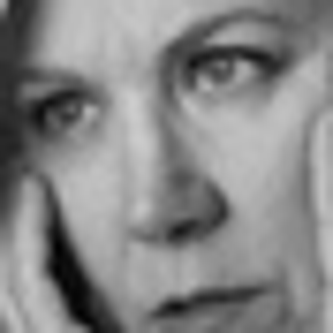

In [19]:
#sample data
sample_image = train[0][0]
sample_image = sample_image[0]
Image.fromarray((sample_image.numpy()*255).astype(np.uint8).reshape(44, 44)).resize((333, 333))

In [20]:
#reset
sample_image = train[0][0]

##model weights + features


In [21]:
#feature extractor 
model = torchvision.models.vgg19(pretrained=True)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [22]:
#convolution layer
sample_conv = model.features[0]
sample_conv.weight.shape #c x h x w for c x h x w of image -> add 64 for new channels

torch.Size([64, 3, 3, 3])

In [23]:
#feature representation
train_dataloader = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test, batch_size=1, shuffle=True)

In [24]:
#sample batch
data, label = iter(train_dataloader).next()

In [25]:
sample_conv(sample_image.view((-1,) + sample_image.shape)).shape

torch.Size([1, 64, 44, 44])

In [26]:
#view the feature maps and weights
sample_map = sample_conv(sample_image.view((-1,) + sample_image.shape))
weight = sample_conv.weight
weight.shape

torch.Size([64, 3, 3, 3])

In [27]:
grid_img_weight = torchvision.utils.make_grid(weight[:, 0, :].view(64, -1, 3, 3), nrows=8, ncols=8)
grid_img_map = torchvision.utils.make_grid(sample_map.view(64, 1, 44, 44), nrows=8, ncols=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


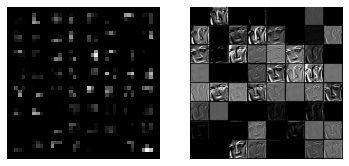

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(grid_img_weight.permute(1, 2, 0))
ax1.axis(False)
ax2.imshow(grid_img_map.permute(1, 2, 0))
ax2.axis(False)
plt.show()

##triplet loss

In [30]:
#essentials
import os
#ds
import pandas as pd
import numpy as np
from PIL import Image
import pandas as pd
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch
#dl
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torch.nn as nn 
import random


class RankingSet(Dataset):
    def __init__(self, data_dir, mode=False, train=True):
        super().__init__()
        self.mode = mode
        self.data = pd.read_feather(data_dir)
        self.train = train
        if self.train:
            self.transform = transforms.Compose([
        transforms.RandomCrop(44),
        transforms.ToTensor()
        ])
        else:
            self.transform = transforms.Compose([
                                transforms.TenCrop(44), 
                                transforms.Lambda(lambda x: torch.stack([transforms.ToTensor()(i) for i in x])) #stack the tensors along new dimension
        ])
        self.class_df = [self.data.loc[self.data['label'] == i, :] for  i in range(7)]

    def __getitem__(self, idx):
        #read
        #anchor
        img, label = self.data.iloc[idx]['pixel'], self.data.iloc[idx]['label']
        #positive
        pos_df = self.class_df[label]
        pos_idx = random.randint(0, len(pos_df)-1)
        pos_img = pos_df.iloc[pos_idx]['pixel']
        #negative
        idx = 0
        while idx == label:
          idx = random.randint(0, 6) 
        negav_df = self.class_df[idx]
        negav_idx = random.randint(0, len(negav_df)-1)
        negav_img = negav_df.iloc[negav_idx]['pixel']
         
        #transform
        img = np.array(img.tolist()).reshape(48, 48).astype(np.uint8)
        img = Image.fromarray(img)

        pos_img = np.array(pos_img.tolist()).reshape(48, 48).astype(np.uint8)
        pos_img = Image.fromarray(pos_img)
        
        negav_img = np.array(negav_img.tolist()).reshape(48, 48).astype(np.uint8)
        negav_img = Image.fromarray(negav_img)
        #transform
        img = self.transform(img)
        pos_img = self.transform(pos_img)
        negav_img = self.transform(negav_img)
        label = torch.tensor([label], dtype=torch.long)
        #if use pretrained model, have to switch to 3d
        if self.mode:
            if self.train:
                img = torch.concat([img, img, img], dim=0)
                pos_img = torch.concat([pos_img, pos_img, pos_img], dim=0)
                negav_img = torch.concat([negav_img, negav_img, negav_img], dim=0)
            else: 
                img = torch.concat([img, img, img], dim=1)
            
        return img, pos_img, negav_img, label
    def __len__(self):
        return len(self.data)


In [ ]:
triplet_data = RankingSet("/content/ML_project_midterm-/data/processed/train.ftr", train=True, mode=True)
triplet_dataloader = DataLoader(triplet_data, batch_size=32, shuffle=True, drop_last=True)

In [ ]:
feature_net = model
feature_net.classifier = nn.Sequential(*feature_net.classifier[:6])
feature_net = feature_net.cuda()
feature_net.train()
optimizer = torch.optim.Adam(params=feature_net.parameters(), lr=1e-3)
criterion = nn.TripletMarginLoss(margin=1)
total_loss = []

In [ ]:
from tqdm.auto import tqdm
for i in range(20):
  epoch_loss = 0
  for j, (anchor, pos, negav, label) in tqdm(enumerate(triplet_dataloader)):
    optimizer.zero_grad()
    anchor = feature_net(anchor.cuda())
    pos = feature_net(pos.cuda())
    negav = feature_net(negav.cuda())
    loss = criterion(anchor, pos, negav)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    if j % 20 == 0:
      print(f"loss: {loss.item()}")
  total_loss.append(epoch_loss)


In [ ]:
plt.plot(total_loss)

##loss sanity check


In [ ]:
anchor, pos, negav, label = iter(triplet_dataloader).next()

In [ ]:
anchor = feature_net(anchor.cuda())
pos = feature_net(pos.cuda())
negav = feature_net(negav.cuda())

In [ ]:
pos_dist = ((anchor - pos).pow(2).sum(1))**0.5
neg_dist = ((anchor - negav).pow(2).sum(1))**0.5
loss = nn.functional.relu(pos_dist - neg_dist + 1)
loss.mean()

In [ ]:
#norm vs pow 
my_dist = torch.tensor([torch.norm(anchor[i] - pos[i], 2) for i in range(anchor.shape[0])])
my_dist.mean(), pos_dist.mean()



In [ ]:
def batch_norm(norm, p=2, reduction='mean'):
  norm = torch.tensor([torch.norm(norm[i], p) for i in range(norm.shape[0])])  #batch size
  return norm

In [ ]:
#f = max(x, 0)
(nn.functional.relu(1 + batch_norm(anchor - pos, 2) - batch_norm(anchor - negav, 2))).mean(),  nn.TripletMarginLoss(p=2, reduction='mean')(anchor, pos, negav)